In [19]:
from lib.utilities import *
import matplotlib.pyplot as plt


In [20]:
# automation, can be overridden in next cell
assign_ascending_recording_numbers = True
slice_no = 1
location_no = 1
recording_no = 1
combine_trials = False # Not implemented. Treats selected files as trials to combine into single ZDA file
filename_PhotoZ_format = True # whether to write slice_loc_rec.zda as filename. Else reuse *.tsm -> *.zda

filename_base = "Untitled"
filename_start_no = 14
filename_end_no = 18
camera_program = 4

In [21]:
file_type = '.tsm'
datadir = "./tsm_targets/05-31-22/1-0" # All files in this directory + subdirectories are loaded
# datadir = "C:/Turbo-SM/SMDATA/John/05-31-22" # on new rig
selected_filenames = ["Untitled014", "Untitled015", "Untitled016", "Untitled017", "Untitled018",
                     "Untitled019", "Untitled020", "Untitled021", "Untitled022", "Untitled023"]
selected_filenames = [filename_base + "0" + str(i) for i in range(filename_start_no, filename_end_no+1)]
print(selected_filenames)

['Untitled014', 'Untitled015', 'Untitled016', 'Untitled017', 'Untitled018']


In [22]:
cam_settings = CameraSettings().get_program_settings(camera_program)
print(cam_settings)

t_cropping = [0, -1]  # to handle artifacts
binning = int(cam_settings['height'] / 80)  # recommended binning, adjust as desired

{'interval_between_samples': 0.5, 'width': 512, 'height': 160, 'camera_program': 4, 'cropping': [176, 336]}


In [23]:
# Load data
data_loader = DataLoader()
if file_type == '.tsm':
    selected_filename = None  # set to a filename if there's only one you want to load, to avoid processing everything
    data_loader.load_all_tsm(data_dir=datadir, file_only=selected_filename)
    
print(data_loader.get_n_files_loaded(), "files loaded.")

Untitled014.tbn
Untitled014.tsm
./tsm_targets/05-31-22/1-0/Untitled014.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 512, 'raw_height': 160, 'interval_between_samples': 0.5, 'number_of_trials': 1}
Untitled015.tbn
Untitled015.tsm
./tsm_targets/05-31-22/1-0/Untitled015.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 512, 'raw_height': 160, 'interval_between_samples': 0.5, 'number_of_trials': 1}
Untitled016.tbn
Untitled016.tsm
./tsm_targets/05-31-22/1-0/Untitled016.tsm to be treated as TSM file to open
Reading file as 200 images of size 512 x 160
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 512, 'raw_height':

In [24]:
# Select data of interest        
selected_datasets = [data_loader.select_data_by_keyword(fn) for fn in selected_filenames]

# binning and cropping
for i in range(len(selected_datasets)):
    sd = selected_datasets[i]
    if sd is None:
        print("Dataset not found:", selected_filenames[i])
    sd.clip_data(y_range=cam_settings['cropping'], t_range=t_cropping)
    sd.bin_data(binning=binning)

# load data
datasets = [{'filename': selected_filenames[i],
             'raw_data': selected_datasets[i].get_data(),
             'meta': selected_datasets[i].get_meta(),
             'rli': selected_datasets[i].get_rli(),
             'fp_data': selected_datasets[i].fp_data}
             for i in range(len(selected_datasets))]

{'points_per_trace': 199, 'raw_width': 199, 'raw_height': -40, 'interval_between_samples': 0.5, 'number_of_trials': 1} (1, 199, 159, 160)
{'points_per_trace': 199, 'raw_width': 199, 'raw_height': -40, 'interval_between_samples': 0.5, 'number_of_trials': 1} (1, 199, 159, 160)
{'points_per_trace': 199, 'raw_width': 199, 'raw_height': -40, 'interval_between_samples': 0.5, 'number_of_trials': 1} (1, 199, 159, 160)
{'points_per_trace': 199, 'raw_width': 199, 'raw_height': -40, 'interval_between_samples': 0.5, 'number_of_trials': 1} (1, 199, 159, 160)
{'points_per_trace': 199, 'raw_width': 199, 'raw_height': -40, 'interval_between_samples': 0.5, 'number_of_trials': 1} (1, 199, 159, 160)


(1, 199, 80, 80)


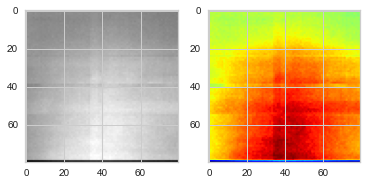

(1, 199, 80, 80)


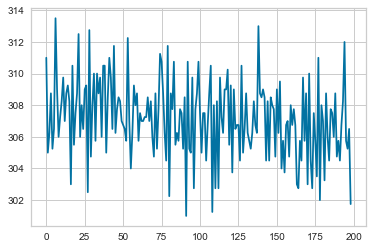

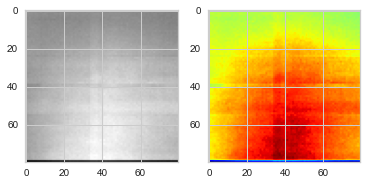

(1, 199, 80, 80)


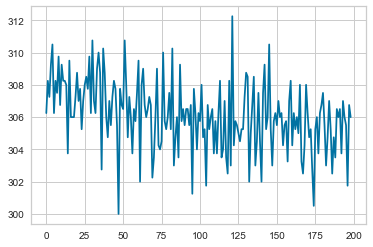

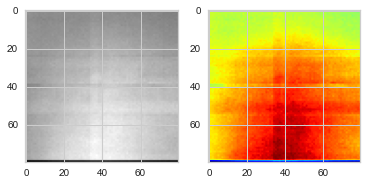

(1, 199, 80, 80)


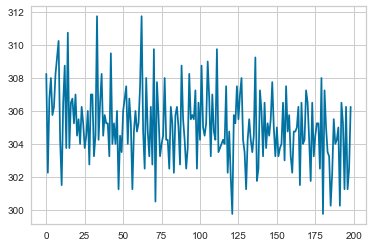

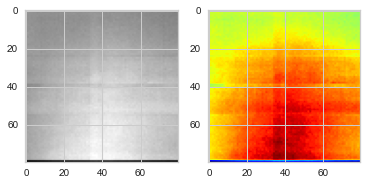

(1, 199, 80, 80)


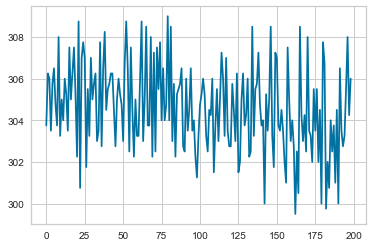

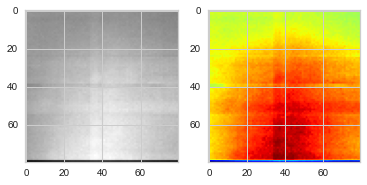

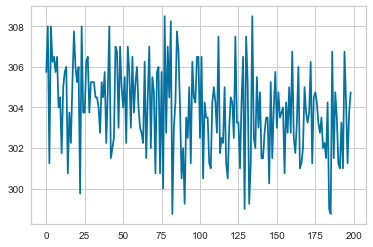

In [25]:
# if we're just one off, auto-correct for the user
for data in datasets:
    if data['raw_data'].shape[2] - data['raw_data'].shape[3] == 1:
        data['raw_data'] = raw_data[:, :, :-1, :]
    elif data['raw_data'].shape[3] - data['raw_data'].shape[2] == 1:
        data['raw_data'] = data['raw_data'][:, :, :, :-1]
    print(data['raw_data'].shape)

    # view frames
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(data['raw_data'][0,0,:,:],cmap='gray')
    axes[1].imshow(data['raw_data'][0,-1,:,:],cmap='jet')
    plt.show()

    data['rli_high_cp'] = np.copy(data['raw_data'][0,0,:,:]).astype(np.uint16)
    plt.subplots()
    plt.plot(data['raw_data'][0,:,0,0])

    # final check 
    if data['raw_data'].shape[2] != data['raw_data'].shape[3]:
        raise Exception("PhotoZ will not work with non-square array! Adjust cropping and/or binning")

In [26]:
# Fill in missing metadata as needed
for data in datasets:
    meta = data['meta']
    raw_data = data['raw_data']
    rli = data['rli']
    
    data['meta']['version'] = 5
    data['meta']['slice_number'] = slice_no
    data['meta']['location_number'] = location_no
    data['meta']['record_number'] = recording_no
    if assign_ascending_recording_numbers:
        recording_no += 1
    data['meta']['camera_program'] = cam_settings['camera_program']

    data['meta']['interval_between_trials'] = 1
    data['meta']['acquisition_gain'] = 1
    data['meta']['time_RecControl'] = 5

    data['meta']['reset_onset'] = 1
    data['meta']['reset_duration'] = 5
    data['meta']['shutter_onset'] = 5
    data['meta']['shutter_duration'] = 5

    data['meta']['stimulation1_onset'] = 20
    data['meta']['stimulation1_duration'] = 1
    data['meta']['stimulation2_onset'] = 0
    data['meta']['stimulation2_duration'] = 0

    data['meta']['acquisition_onset'] = 1
    data['meta']['interval_between_samples'] = cam_settings['interval_between_samples']

    data['meta']['raw_width'] = raw_data.shape[2]
    data['meta']['raw_height'] = raw_data.shape[3]
    data['meta']['points_per_trace'] = raw_data.shape[1]
    data['meta']['number_of_trials'] = raw_data.shape[0]
    data['meta']['num_fp_pts'] = 8
    num_diodes = int(meta['raw_width'] * meta['raw_height'] + meta['num_fp_pts'])
    data['rli'] = {}
    data['rli']['rli_low'] = np.zeros((num_diodes), dtype = np.uint16)
    data['rli']['rli_high'] = np.zeros((num_diodes), dtype = np.uint16) 
    data['rli']['rli_high'][:meta['raw_width'] * meta['raw_height']] = data['rli_high_cp'].reshape(-1)
    data['rli']['rli_max'] = np.ones((num_diodes), dtype = np.uint16)


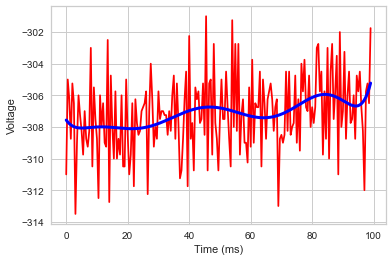

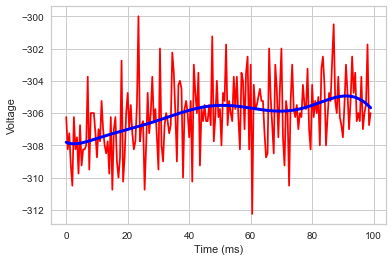

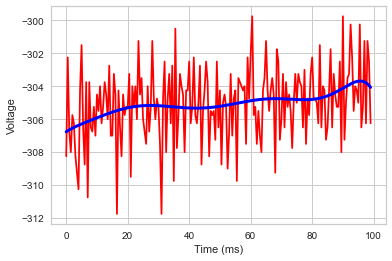

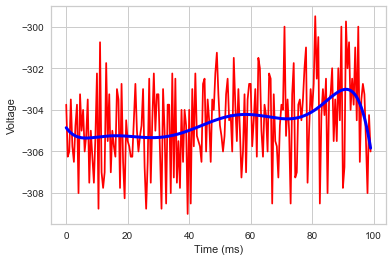

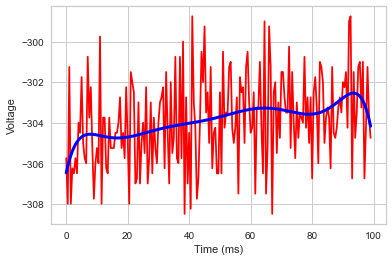

In [27]:
# Run this cell at most once
for data in datasets:
    
    # Apply baseline correction here. Because PhotoZ chokes on baseline correcting TurboSM data
    tr = Tracer()
    #data inversing
    data['raw_data'] = -data['raw_data']

    # Need to subtract off the low-frequency voltage drift. First-order correction
    tr.correct_background(data['meta'], data['raw_data'])
    #plt.subplots() # finalize plot 

(1, 199, 80, 80)


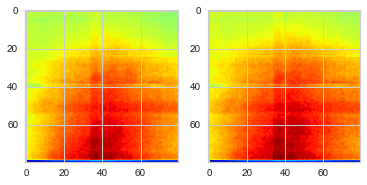

(1, 199, 80, 80)


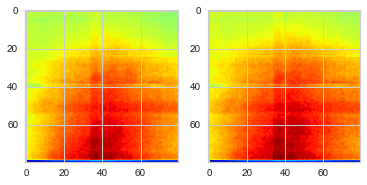

(1, 199, 80, 80)


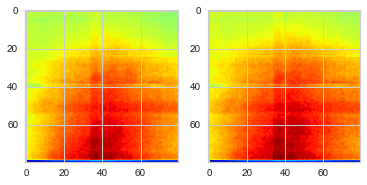

(1, 199, 80, 80)


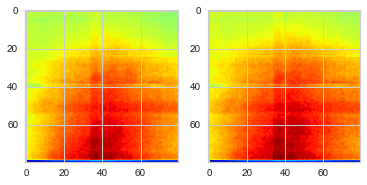

(1, 199, 80, 80)


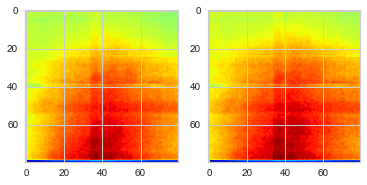

In [28]:
for data in datasets:

    # normalize raw data to 12-bit range
    data['fp_data'] = normalize_bit_range(data['fp_data'])
    data['raw_data'] = normalize_bit_range(data['raw_data'])

    # view frames
    fig, axes = plt.subplots(1, 2)
    print(data['raw_data'].shape)
    axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
    axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
    plt.show()


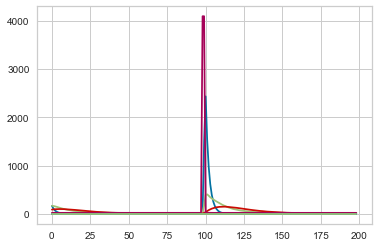

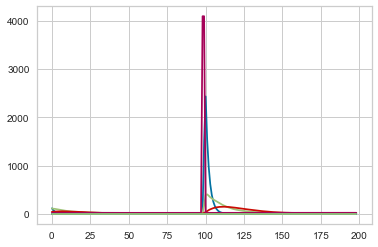

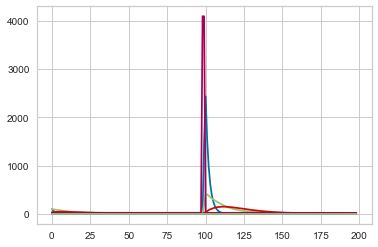

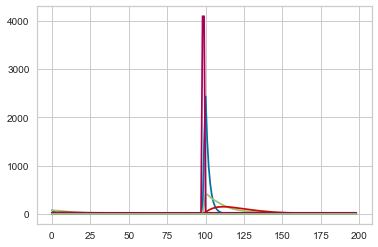

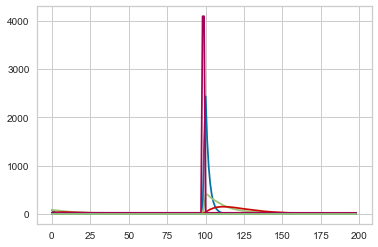

In [29]:
# resize FP data
for data in datasets:
    meta = data['meta']
    fp_data = data['fp_data']
    
    fp_data_final = np.zeros((fp_data.shape[0], meta['num_fp_pts']))
    fp_data_final[:, :fp_data.shape[1]] = fp_data[:, :]
    data['fp_data'] = np.swapaxes(fp_data_final, 1, 0)

    fig, ax = plt.subplots()
    ax.plot(fp_data_final[t_cropping[0]:t_cropping[1], :])

In [30]:
# Write data
for data in datasets:
    meta = data['meta']
    raw_data = data['raw_data']
    rli = data['rli']
    fp_data = data['fp_data']
    if filename_PhotoZ_format:
        data['filename'] = str(meta['slice_number']) + "_" + str(meta['location_number']) + "_" + str(meta['record_number'])
    
    zda_writer = ZDA_Writer()
    zda_writer.write_zda_to_file(raw_data, meta, data['filename'] + ".zda", rli, fp_data[:, t_cropping[0]:t_cropping[1]])
    print("Written to " + data['filename'] + ".zda")

Written to 1_1_1.zda
Written to 1_1_2.zda
Written to 1_1_3.zda
Written to 1_1_4.zda
Written to 1_1_5.zda
